# Visualization

In [1]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import yaml
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('conf/mpl.sty') 

In [4]:
import geopandas as gpd
import altair as alt

import folium
from folium.plugins import StripePattern
import branca

with open('conf/map.yaml', 'r') as f:
    map_cfg = yaml.safe_load(f)

In [5]:
with open('data/iwp.pkl', 'rb') as f:
    dfs = pickle.load(f)

In [6]:
import warnings
warnings.filterwarnings("ignore")

## 1. Plot `Per Capita Water Availability`

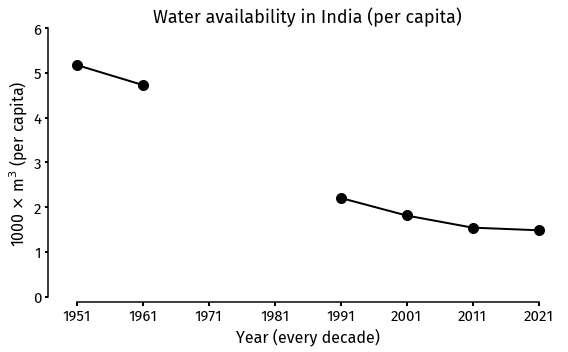

In [7]:
df = dfs['Per Capita Water Availability'].copy()

plt.figure(figsize=(8,5))

plt.plot(
    df.year, 
    df.water_availability_m3_per_capita / 1000,
    '-ko', 
    lw=2,
    markersize=10,
)

plt.xlabel('Year (every decade)')
plt.ylabel(r'1000 $\times$ m$^3$ (per capita)')
plt.ylim([0, 6])
plt.xticks(df.year, df.year)
plt.title('Water availability in India (per capita)')

sns.despine(trim=True, offset=5)
plt.tight_layout()

plt.savefig('figures/water_avail.svg', format='svg')


plt.show()

## 2. Plot `Monsoon performance`

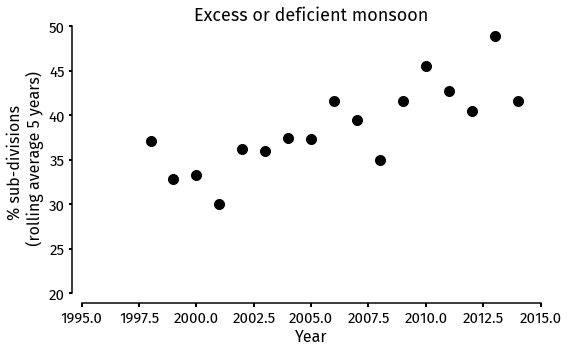

In [8]:
plt.figure(figsize=(8,5))

dfs['Monsoon performance'].assign(
    nsubdiv_notnormal = lambda x: x.nsubdiv_excess + x.nsubdiv_deficient,
    nsubdiv_total = lambda x: x.nsubdiv_normal + x.nsubdiv_notnormal,
    percent_normal = lambda x: 100 * x.nsubdiv_normal / x.nsubdiv_total,
    percent_notnormal = lambda x: 100 - x.percent_normal
).rolling(
    window = 5, 
    on = 'year', 
    min_periods=1,
).mean().plot(
    x = 'year', 
    y = 'percent_notnormal',
    marker = '.',
    c = 'k',
    linestyle = 'none',
    legend = False,
    ax = plt.gca()
)

plt.xlabel('Year')
plt.ylabel('% sub-divisions \n (rolling average 5 years)')
plt.title('Excess or deficient monsoon')
plt.xlim([1995, 2015])
plt.ylim([20, 50])

sns.despine(trim=True, offset=10)
plt.tight_layout()

plt.savefig('figures/monsoon_performance.svg', format='svg')

plt.show()



## 3. Utils for map plotting 

In [9]:
state_remap = { # consistent naming
    'Orissa' : 'Odisha',
    'Uttaranchal' : 'Uttarakhand',
    'Daman&Diu': 'Daman and Diu',
    'J&K': 'Jammu and Kashmir',
    'Jharkhund': 'Jharkhand',
    'Pondicherry': 'Puducherry',
}

def clean_name(df, field):
     df[field] = df[field].apply(
         lambda s: s.strip().title().replace(' And ', ' and ').replace(' & ', ' and ')
     )
        
def correct_state(df, state_remap):
    state_map = list(df.state.unique())
    state_map = dict(zip(state_map, state_map))
    state_map.update(**state_remap)
    df.state = df.state.map(state_map)
    
def load_shape(d, tolerance=0.1):
    columns = d['columns']
    gdf = gpd.read_file(d['file'])\
            .filter(list(columns.keys()))\
            .rename(columns=columns)
    clean_name(gdf, 'state')
    if 'district' in gdf:
        clean_name(gdf, 'district')
    correct_state(gdf, state_remap)
    gdf['geometry'] = gdf['geometry'].apply(
        lambda x: x.simplify(tolerance=tolerance)
    )
    return gdf


def _style_fn(prop, cmap):
    return lambda feature: dict(
        fillPattern = sp if feature['properties'][prop] is None else None, 
        fillColor = None if (_val:=feature['properties'][prop]) is None else cmap(_val),
        **common_config.get('geojson_style', {})
        )

# source: <https://stackoverflow.com/a/62914251>
def keep_group_in_front(m, g):
    js_keep_in_front = f"""
        {m.get_name()}.on("baselayerchange", function (event) {{
          {g.get_name()}.bringToFront();
        }});
    """
    e = branca.element.Element(js_keep_in_front)
    html = m.get_root()
    html.script.get_root().render()
    html.script._children[e.get_name()] = e


In [10]:
gis_files = dict(
    state = dict(
        file = 'gis/IND_adm1.shp',
        columns = dict(
            NAME_1 = 'state', 
            TYPE_1 = 'type', 
            geometry = 'geometry'
        )
    ),
    district = dict(
        file = 'gis/IND_adm2.shp',
        columns = dict(
            NAME_1 = 'state', 
            NAME_2 = 'district', 
            geometry = 'geometry'
        )
    )
)
tolerance = map_cfg['gpd']['tolerance'] # increase to reduce generated html
gdfs = {k: load_shape(v, tolerance=tolerance) 
        for k, v in gis_files.items()}

## 4. Plot `District wise rainfall`

### 4.1. Process data

In [11]:
df_rainfall = dfs['District wise rainfall']\
                .query('year >= 1980')\
                .dropna()\
                .reset_index(drop=True)\
                .assign(
                    percent_other = lambda x : 100*(
                        1 - x.monsoon_rainfall_mm / x.annual_rainfall_mm
                    )
                )

df_rainfall.state = df_rainfall.state.str.title()
df_rainfall.district = df_rainfall.district.str.title()

In [12]:
df_mean_rain = df_rainfall.drop(columns='district')\
                .sort_values(by='year')\
                .groupby(['state', 'year'])\
                .agg(np.nanmean)\
                .reset_index()\
                .groupby('state')\
                .rolling(  
                    window = 5, 
                    on = 'year',
                    min_periods=1, 
                    center=True
                ).mean()\
                .reset_index()

In [13]:
df_rainfall_stats = []
for state in df_mean_rain.state.unique():
    _df_state = df_mean_rain.query('state == @state')
    _linear_fit = np.polyfit(_df_state.year, _df_state.percent_other, deg=1)
    x = _df_state.year.to_numpy()
    y = _df_state.percent_other.to_numpy()
    loc_x0 = x < 2000
    loc_x1 = (x >= 2000) & (x < 2010)
    loc_x2 = x >= 2010
    
    df_rainfall_stats.append(dict(
        state = state,
        d1 = np.nanmean(y[loc_x1]) - np.nanmean(y[loc_x0]),
        d2 = np.nanmean(y[loc_x2]) - np.nanmean(y[loc_x1]),
        slope = _linear_fit[0]
    ))
    
df_rainfall_stats = pd.DataFrame(df_rainfall_stats)


### 4.2. Plot map of rainfall stats

In [14]:
common_config = dict(
    colors = ['#d73027', '#f46d43', '#fdae61', '#fee090', '#ffffbf', '#e0f3f8', '#abd9e9', '#74add1', '#4575b4'][::-1],
    geojson = map_cfg['geojson'].get('__root__', dict()),
    geojson_style = map_cfg['geojson'].get('style', dict()),
    geojson_tooltip = dict(
        fields=['state','type','slope','d2', 'd1'],
        aliases=['Name',"Type",'Slope','Difference [2010s - 2000s]', 'Difference [2000s - before]'],
        **map_cfg['geojson'].get('tooltip', dict())
    ),
)

data_config = dict(
    slope = dict(
        cmap_kwargs = dict(
            vmin=-0.5, vmax=0.5,
            caption='Annual rainfall percentage not from monsoon - Fitted slope (%/year)'
        ),
        geojson = dict(
            name = 'slope',
        ),
    ),    
    d2 = dict(
        cmap_kwargs = dict(
            vmin=-12, vmax=12,
            caption='% Difference between 2010s and 2000s'
        ),
        geojson = dict(
            name = 'difference [2010s - 2000s]',
        ),
    ),
    d1 = dict(
        cmap_kwargs = dict(
            vmin=-12, vmax=12,
            caption='% Difference between 2000s and before 2000'
        ),
        geojson = dict(
            name = 'difference [2000s - before]',
        ),
    ),
)


In [15]:
gdf = gdfs['state'].merge(df_rainfall_stats, on = 'state')

white_tile = branca.utilities.image_to_url([[1, 1], [1, 1]])

f = folium.Figure(width=1800, height=1200)

m = folium.Map(**map_cfg['map']).add_to(f)

folium.TileLayer(
    white_tile, 
    attr='white tile',
    name='white tile',
    overlay=True,
    control=False,
    show=True
).add_to(m)
    
sp = StripePattern(angle=45, color='grey', space_color='white')
sp.add_to(m)

for i, (prop, conf) in enumerate(data_config.items()):
    cmap = branca.colormap.LinearColormap(
        colors=common_config['colors'],
        **conf['cmap_kwargs']
    )
    cmap.add_to(m)
    
    folium.GeoJson(
        gdf,
        style_function = _style_fn(prop, cmap),
        tooltip = folium.features.GeoJsonTooltip(**common_config['geojson_tooltip']),
        show=i==1,
        **conf.get('geojson', {}),
        **common_config.get('geojson', {})
    ).add_to(m)


markers = folium.FeatureGroup(name="time series")
keep_group_in_front(m, markers)

for _, row in gdf.iterrows():
    state = row.state
    geom = row.geometry
    
    if hasattr(geom, 'geoms'):
        _geom = geom.geoms
        _areas = np.array([_g.area for _g in _geom])
        geom = _geom[_areas.argmax()]
    centroid = geom.centroid
    
    folium.CircleMarker(
        location = [centroid.y, centroid.x],
        radius = 6,
        fill_opacity = 0.5, 
        fill_color = 'black',
        color = None,
        popup = folium.Popup().add_child(          
            folium.features.VegaLite(
                alt.Chart(
                    df_mean_rain.query('state == @state')\
                        .reset_index(drop=True).dropna()
                ).mark_line(
                    point={"filled": True}
                ).encode(
                    x='year',
                    y=alt.Y('percent_other', axis=alt.Axis(title='% not monsoon')),
                ).configure_axis(
                    grid=False
                ).configure_view(
                    strokeWidth=0
                ).properties(
                    width=300,
                    height=180,
                    title=state
                )
                ,
                width="95%", 
                height="90%"
            )
        )
    ).add_to(markers)

markers.add_to(m)
    
folium.LayerControl(autoZIndex=True).add_to(m)
    
f.save('figures/state_rainfall_map.html')


## 5. Plot `Status of GW dev` and `Water Quality`

### 5.1. Process data and combine

In [16]:
df_status = dfs['Status of GW dev']
df_status.dev_status = df_status.dev_status.apply(
    lambda x: x.replace('_', '-').replace('-', '').lower().strip()
)
clean_name(df_status, 'state')

correct_state(df_status, state_remap)

df_status = df_status.query('dev_status in ["overexploited", "critical"]')\
                .filter(['state', 'district', 'dev_status'])\
                .reset_index(drop=True)


In [17]:
df_qual = dfs['Water Quality']
clean_name(df_qual, 'state')
correct_state(df_qual, state_remap)

In [18]:
def process_groupcounts_devstatus(
    df, 
    by=['state', 'dev_status'], 
    index='state', 
    prefix='num_', 
    suffix=''
):
    df = df.groupby(by=by)\
            .size().unstack(fill_value=0)\
            .reset_index()\
            .rename_axis(None, axis=1)\
            .set_index(index)\
            .add_prefix(prefix)\
            .add_suffix(suffix)
    return df

In [19]:
df_dev_and_qual = pd.concat(
    [
        process_groupcounts_devstatus(
            df_status.filter(['state', 'dev_status']),
            suffix = '_dev_blocks'
        ),
        process_groupcounts_devstatus(
            df_status.drop_duplicates(),
            suffix = '_dev_districts'
        ),   
        df_qual.set_index('state').filter(regex='num*') 
    ],
    axis = 1
).reset_index()

### 5.2. Plot map of both

In [20]:
gdf = gdfs['state'].merge(df_dev_and_qual, on='state')

white_tile = branca.utilities.image_to_url([[1, 1], [1, 1]])

f = folium.Figure(width=1800, height=1200)

m = folium.Map(**map_cfg['map']).add_to(f)

folium.TileLayer(
    white_tile, 
    attr='white tile',
    name='white tile',
    overlay=True,
    control=False,
    show=True
).add_to(m)

sp = StripePattern(angle=45, color='grey', space_color='white')
sp.add_to(m)

data_cols = [x for x in gdf.columns
             if x.startswith('num') and x != 'state']

def _label(prop, is_legend=False):
    label = prop.replace('_', ' ').replace('num', '#').strip()
    if not is_legend:
        return label
    
    if 'dev' in label:
        label = 'Dev. Status | ' + label.replace('dev', '').strip().title()
    else:
        label = 'Water quality | ' + label.strip().title()
    return label

def _color(label):
    if 'dev' in label:
        return ['white', 'green']
    else:
        return ['white', 'red']

common_config = common_config.copy()
common_config['geojson_tooltip'].update(dict(
    fields=['state','type'] + data_cols,
    aliases=['Name',"Type"] + list(map(_label, data_cols))
))
                                  
for i, prop in enumerate(data_cols):
    cmap = branca.colormap.LinearColormap(
        colors=_color(prop),
        caption=_label(prop, is_legend=True),
        vmin=np.nanmin(gdf[prop]),
        vmax=np.nanmax(gdf[prop]),
    )
    cmap.add_to(m)
    
    def _style_fn(prop, cmap):
        return lambda feature: dict(
            fillPattern = sp if feature['properties'][prop] is None else None, 
            fillColor = None if (_val:=feature['properties'][prop]) is None else cmap(_val),
            **common_config.get('geojson_style', {})
        )
    
    folium.GeoJson(
        gdf,
        style_function = _style_fn(prop, cmap),
        tooltip = folium.features.GeoJsonTooltip(**common_config['geojson_tooltip']),
        name=_label(prop),
        show=i==0,
        overlay=False,
    ).add_to(m)
        
folium.LayerControl(autoZIndex=True).add_to(m)
    
f.save('figures/dev-status_and_water-quality_map.html')
